In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, interpolate, signal
import seaborn as sns
from datetime import datetime
from scipy import signal, interpolate
from sklearn.metrics import r2_score
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

# Publication color scheme
PUB_GRAY = '#cecece'
PUB_PURPLE = '#a559aa'
PUB_TEAL = '#59a89c'
PUB_GOLD = '#f0c571'
PUB_RED = '#e02b35'
PUB_BLUE = '#082a54'

def setup_publication_style():
    """
    Configure matplotlib parameters for publication-quality figures.
    """
    plt.rcParams.update({
        'font.size': 20,
        'font.family': 'Helvetica',
        'font.weight': 'regular',
        'mathtext.fontset': 'stix',
        
        'figure.figsize': [10, 6],
        'figure.dpi': 300,
        
        'axes.linewidth': 1.2,
        'axes.labelsize': 22,
        'axes.labelweight': 'regular',
        'axes.grid': True,
        'axes.titlesize': 20,
        
        'lines.linewidth': 2.0,
        'lines.markersize': 6,
        'lines.markeredgewidth': 1,
        
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.minor.visible': True,
        'ytick.minor.visible': True,
        
        'legend.fontsize': 20,
        'legend.frameon': True,
        'legend.fancybox': True,
        'legend.shadow': False,
        'legend.framealpha': 0.95,
        
        'savefig.bbox': 'tight',
        'savefig.dpi': 300,
        'savefig.format': 'png'
    })

def calculate_phase_contributions(df, coefficients, T_ref, H_ref, P_ref, wavelength=1762e-9, L=4.2):
    """
    Calculate phase contributions from environmental parameters.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing 'temperature', 'humidity', 'pressure', 'n_1762' columns
    coefficients : dict
        Dictionary containing sensitivity coefficients:
        - alpha0: base refractive index
        - alphaT: temperature coefficient
        - alphaH: humidity coefficient  
        - alphaP: pressure coefficient
    T_ref, H_ref, P_ref : float
        Reference values for temperature, humidity, and pressure
    wavelength : float, optional
        Laser wavelength in meters (default: 1762e-9 m)
    L : float, optional
        Cavity length in meters (default: 4.2 m)
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with added phase calculation columns
    """
    df = df.copy()
    
    # Calculate phase conversion factor
    conversion_factor = (2 * np.pi / wavelength) * L
    
    # Calculate measured phase
    n_ref = df['n_1762'].iloc[0]
    df['phase_measured'] = (df['n_1762'] - n_ref) * conversion_factor
    
    # Calculate environmental contributions
    df['phase_T'] = coefficients['alphaT'] * (df['temperature'] - T_ref) * conversion_factor
    df['phase_H'] = coefficients['alphaH'] * (df['humidity'] - H_ref) * conversion_factor
    df['phase_P'] = coefficients['alphaP'] * (df['pressure'] * 100 - P_ref) * conversion_factor
    
    # Calculate total environmental contribution and compensated phase
    df['phase_env'] = df['phase_T'] + df['phase_H'] + df['phase_P']
    df['phase_compensated'] = df['phase_measured'] - df['phase_env']
    
    return df

def compute_acf_exact(signal_data, max_lag_seconds):
    """
    Compute exact autocorrelation function.
    
    Parameters:
    -----------
    signal_data : array-like
        Input signal data
    max_lag_seconds : int
        Maximum lag in seconds
        
    Returns:
    --------
    numpy.array
        Autocorrelation function values
    """
    n = len(signal_data)
    max_lag = min(max_lag_seconds, n-1)
    
    # Compute ACF for positive lags
    acf_positive = np.zeros(max_lag + 1)
    for lag in range(max_lag + 1):
        if lag == 0:
            acf_positive[lag] = 1.0
        else:
            acf_positive[lag] = np.corrcoef(signal_data[:-lag], signal_data[lag:])[0, 1]
    
    # Create symmetric ACF
    acf_full = np.concatenate([acf_positive[:0:-1], acf_positive])
    
    return acf_full

def calculate_psd_welch(signal_data, fs, nperseg=1024):
    """
    Calculate power spectral density using Welch's method.
    
    Parameters:
    -----------
    signal_data : array-like
        Input signal data
    fs : float
        Sampling frequency in Hz
    nperseg : int, optional
        Length of each segment (default: 1024)
        
    Returns:
    --------
    tuple
        (frequencies, PSD)
    """
    freqs, psd = signal.welch(signal_data, fs=fs, nperseg=nperseg, 
                             scaling='density', detrend='constant')
    return freqs, psd

def create_combined_figure(df_long_term, df_short_term, coefficients, 
                          QEC_THRESHOLD=0.1, save_path='combined_figure.png'):
    """
    Create comprehensive 2x4 figure showing phase compensation analysis.
    
    Parameters:
    -----------
    df_long_term : pandas.DataFrame
        Long-term dataset (e.g., 1200 hours)
    df_short_term : pandas.DataFrame
        Short-term dataset (e.g., 12 hours)
    coefficients : dict
        Sensitivity coefficients for environmental compensation
    QEC_THRESHOLD : float, optional
        Threshold for quantum error correction (default: 0.1 rad)
    save_path : str, optional
        Path to save the output figure
        
    Returns:
    --------
    tuple
        (figure_object, statistics_dict)
    """
    # Setup publication style
    setup_publication_style()
    
    # Define colors
    color_before = PUB_GOLD   # Uncompensated phase
    color_after = PUB_PURPLE  # Compensated phase
    
    # Create figure with custom layout
    fig = plt.figure(figsize=(14, 5))
    
    # Define layout parameters
    top_height = 0.4      # Top row height
    bottom_height = 0.35  # Bottom row height
    hspace = 0.1          # Row spacing
    wspace1 = 0.2         # Top row column spacing
    wspace2 = 0.5         # Bottom row column spacing
    
    # Margins
    left_margin = 0.08
    right_margin = 0.08
    bottom_margin = 0.1
    top_margin = 0.05
    
    # Calculate positions
    top_bottom = 1 - top_margin - top_height
    top_top = 1 - top_margin
    bottom_bottom = bottom_margin
    bottom_top = bottom_margin + bottom_height
    
    # Create GridSpec objects
    gs_top = gridspec.GridSpec(1, 2, figure=fig,
                              left=left_margin, right=1-right_margin,
                              bottom=top_bottom, top=top_top,
                              wspace=wspace1)
    
    gs_bottom = gridspec.GridSpec(1, 4, figure=fig,
                                 left=left_margin, right=1-right_margin,
                                 bottom=bottom_bottom, top=bottom_top,
                                 wspace=wspace2)
    
    # Process datasets
    datasets = {
        'long_term': df_long_term.copy(),
        'short_term': df_short_term.copy()
    }
    
    processed_data = {}
    statistics = {}
    
    for scale, df in datasets.items():
        df['time'] = pd.to_datetime(df['time'])
        T_ref = df['temperature'].mean()
        H_ref = df['humidity'].mean()
        P_ref = df['pressure'].mean() * 100
        
        processed_data[scale] = calculate_phase_contributions(df, coefficients, T_ref, H_ref, P_ref)
        
        # Calculate statistics
        phase_before = processed_data[scale]['phase_measured'].values
        phase_after = processed_data[scale]['phase_compensated'].values
        
        statistics[scale] = {
            'std_before': np.std(phase_before),
            'std_after': np.std(phase_after),
            'reduction_ratio': np.std(phase_before) / np.std(phase_after),
            'improvement_factor': 20 * np.log10(np.std(phase_before) / np.std(phase_after))
        }
    
    # Top row: Time series plots
    # Left: Long-term time series
    ax1 = fig.add_subplot(gs_top[0, 0])
    df_long = processed_data['long_term']
    
    ax1.plot(df_long['time'], df_long['phase_measured'], '.', markersize=2, 
             color=color_before, alpha=0.7, label='Uncompensated')
    ax1.plot(df_long['time'], df_long['phase_compensated'], '.', markersize=2, 
             color=color_after, alpha=0.8, label='Compensated')
    ax1.axhspan(-QEC_THRESHOLD, QEC_THRESHOLD, alpha=0.9, color=PUB_GRAY)
    ax1.set_ylabel('Phase (rad)')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax1.grid(True, alpha=0.3)
    ax1.text(0.02, 0.98, '(a)', transform=ax1.transAxes, va='top', ha='left')
    
    # Right: Short-term time series
    ax2 = fig.add_subplot(gs_top[0, 1])
    df_short = processed_data['short_term']
    
    ax2.plot(df_short['time'], df_short['phase_measured'], '.', markersize=2, 
             color=color_before, alpha=0.7, label='Uncompensated')
    ax2.plot(df_short['time'], df_short['phase_compensated'], '.', markersize=2, 
             color=color_after, alpha=0.8, label='Compensated')
    ax2.set_ylabel('Phase (rad)')
    ax2.axhspan(-QEC_THRESHOLD, QEC_THRESHOLD, alpha=0.9, color=PUB_GRAY)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax2.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax2.grid(True, alpha=0.3)
    ax2.text(0.02, 0.98, '(d)', transform=ax2.transAxes, va='top', ha='left')
    
    # Bottom row: Analysis plots
    # Panel 1: Long-term ACF
    ax3 = fig.add_subplot(gs_bottom[0, 0])
    phase_before_long = df_long['phase_measured'].values
    phase_after_long = df_long['phase_compensated'].values
    time_diff_long = (df_long['time'].iloc[1] - df_long['time'].iloc[0]).total_seconds()
    fs_long = 1 / time_diff_long
    
    max_lag_long = 500
    acf_before_long = compute_acf_exact(phase_before_long, max_lag_long)
    acf_after_long = compute_acf_exact(phase_after_long, max_lag_long)
    lags_long = np.arange(-max_lag_long, max_lag_long + 1)
    
    ax3.plot(lags_long, acf_before_long, color=color_before, label='Uncompensated', alpha=0.8)
    ax3.plot(lags_long, acf_after_long, color=color_after, label='Compensated')
    ax3.set_xlabel('Time Lag (s)')
    ax3.set_ylabel('Autocorrelation')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(-max_lag_long, max_lag_long)
    ax3.text(0.05, 0.95, '(b)', transform=ax3.transAxes, va='top', ha='left')
    
    # Panel 2: Long-term PSD
    ax4 = fig.add_subplot(gs_bottom[0, 1])
    freqs_before_long, psd_before_long = calculate_psd_welch(phase_before_long, fs_long)
    freqs_after_long, psd_after_long = calculate_psd_welch(phase_after_long, fs_long)
    
    ax4.loglog(freqs_before_long, psd_before_long, color=color_before, 
               label='Uncompensated', alpha=0.8)
    ax4.loglog(freqs_after_long, psd_after_long, color=color_after, 
               label='Compensated', alpha=0.8)
    ax4.set_xlabel('Frequency (Hz)')
    ax4.set_ylabel('PSD (rad²/Hz)')
    ax4.grid(True, alpha=0.3, which='both')
    ax4.set_xlim(np.min(freqs_before_long), fs_long/2)
    ax4.text(0.05, 0.95, '(c)', transform=ax4.transAxes, va='top', ha='left')
    
    # Panel 3: Short-term ACF
    ax5 = fig.add_subplot(gs_bottom[0, 2])
    phase_before_short = df_short['phase_measured'].values
    phase_after_short = df_short['phase_compensated'].values
    time_diff_short = (df_short['time'].iloc[1] - df_short['time'].iloc[0]).total_seconds()
    fs_short = 1 / time_diff_short
    
    max_lag_short = 50
    acf_before_short = compute_acf_exact(phase_before_short, max_lag_short)
    acf_after_short = compute_acf_exact(phase_after_short, max_lag_short)
    lags_short = np.arange(-max_lag_short, max_lag_short + 1)
    
    ax5.plot(lags_short, acf_before_short, color=color_before, label='Uncompensated', alpha=0.8)
    ax5.plot(lags_short, acf_after_short, color=color_after, label='Compensated')
    ax5.set_xlabel('Time Lag (s)')
    ax5.set_ylabel('Autocorrelation')
    ax5.grid(True, alpha=0.3)
    ax5.set_xlim(-max_lag_short, max_lag_short)
    ax5.text(0.05, 0.95, '(e)', transform=ax5.transAxes, va='top', ha='left')
    
    # Panel 4: Short-term PSD
    ax6 = fig.add_subplot(gs_bottom[0, 3])
    freqs_before_short, psd_before_short = calculate_psd_welch(phase_before_short, fs_short)
    freqs_after_short, psd_after_short = calculate_psd_welch(phase_after_short, fs_short)
    
    ax6.loglog(freqs_before_short, psd_before_short, color=color_before, 
               label='Uncompensated', alpha=0.8)
    ax6.loglog(freqs_after_short, psd_after_short, color=color_after, 
               label='Compensated', alpha=0.8)
    ax6.set_xlabel('Frequency (Hz)')
    ax6.set_ylabel('PSD (rad²/Hz)')
    ax6.grid(True, alpha=0.3, which='both')
    ax6.set_xlim(np.min(freqs_before_short), fs_short/2)
    ax6.text(0.05, 0.95, '(f)', transform=ax6.transAxes, va='top', ha='left')
    
    # Add legend
    handles, labels = ax1.get_legend_handles_labels()
    
    # Save figure
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    # Print statistics
    print("=== PHASE COMPENSATION STATISTICS ===")
    for scale, stats_dict in statistics.items():
        print(f"\n{scale.replace('_', ' ').title()}:")
        print(f"  Phase noise std: {stats_dict['std_before']:.3f} → {stats_dict['std_after']:.3f} rad")
        print(f"  Noise reduction: {stats_dict['reduction_ratio']:.1f}x")
        print(f"  Improvement: {stats_dict['improvement_factor']:.1f} dB")
    print("=" * 40)
    
    return fig, statistics

/var/folders/qw/t4bxrq7902q6yx_4ncnk_c_40000gn/T/ipykernel_26451/3078851350.py:317: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax4.set_xlim(np.min(freqs_before_long), fs_long/2)
/var/folders/qw/t4bxrq7902q6yx_4ncnk_c_40000gn/T/ipykernel_26451/3078851350.py:352: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax6.set_xlim(np.min(freqs_before_short), fs_short/2)


=== PHASE COMPENSATION STATISTICS ===

Long Term:
  Phase noise std: 17.938 → 3.414 rad
  Noise reduction: 5.3x
  Improvement: 14.4 dB

Short Term:
  Phase noise std: 6.547 → 2.605 rad
  Noise reduction: 2.5x
  Improvement: 8.0 dB


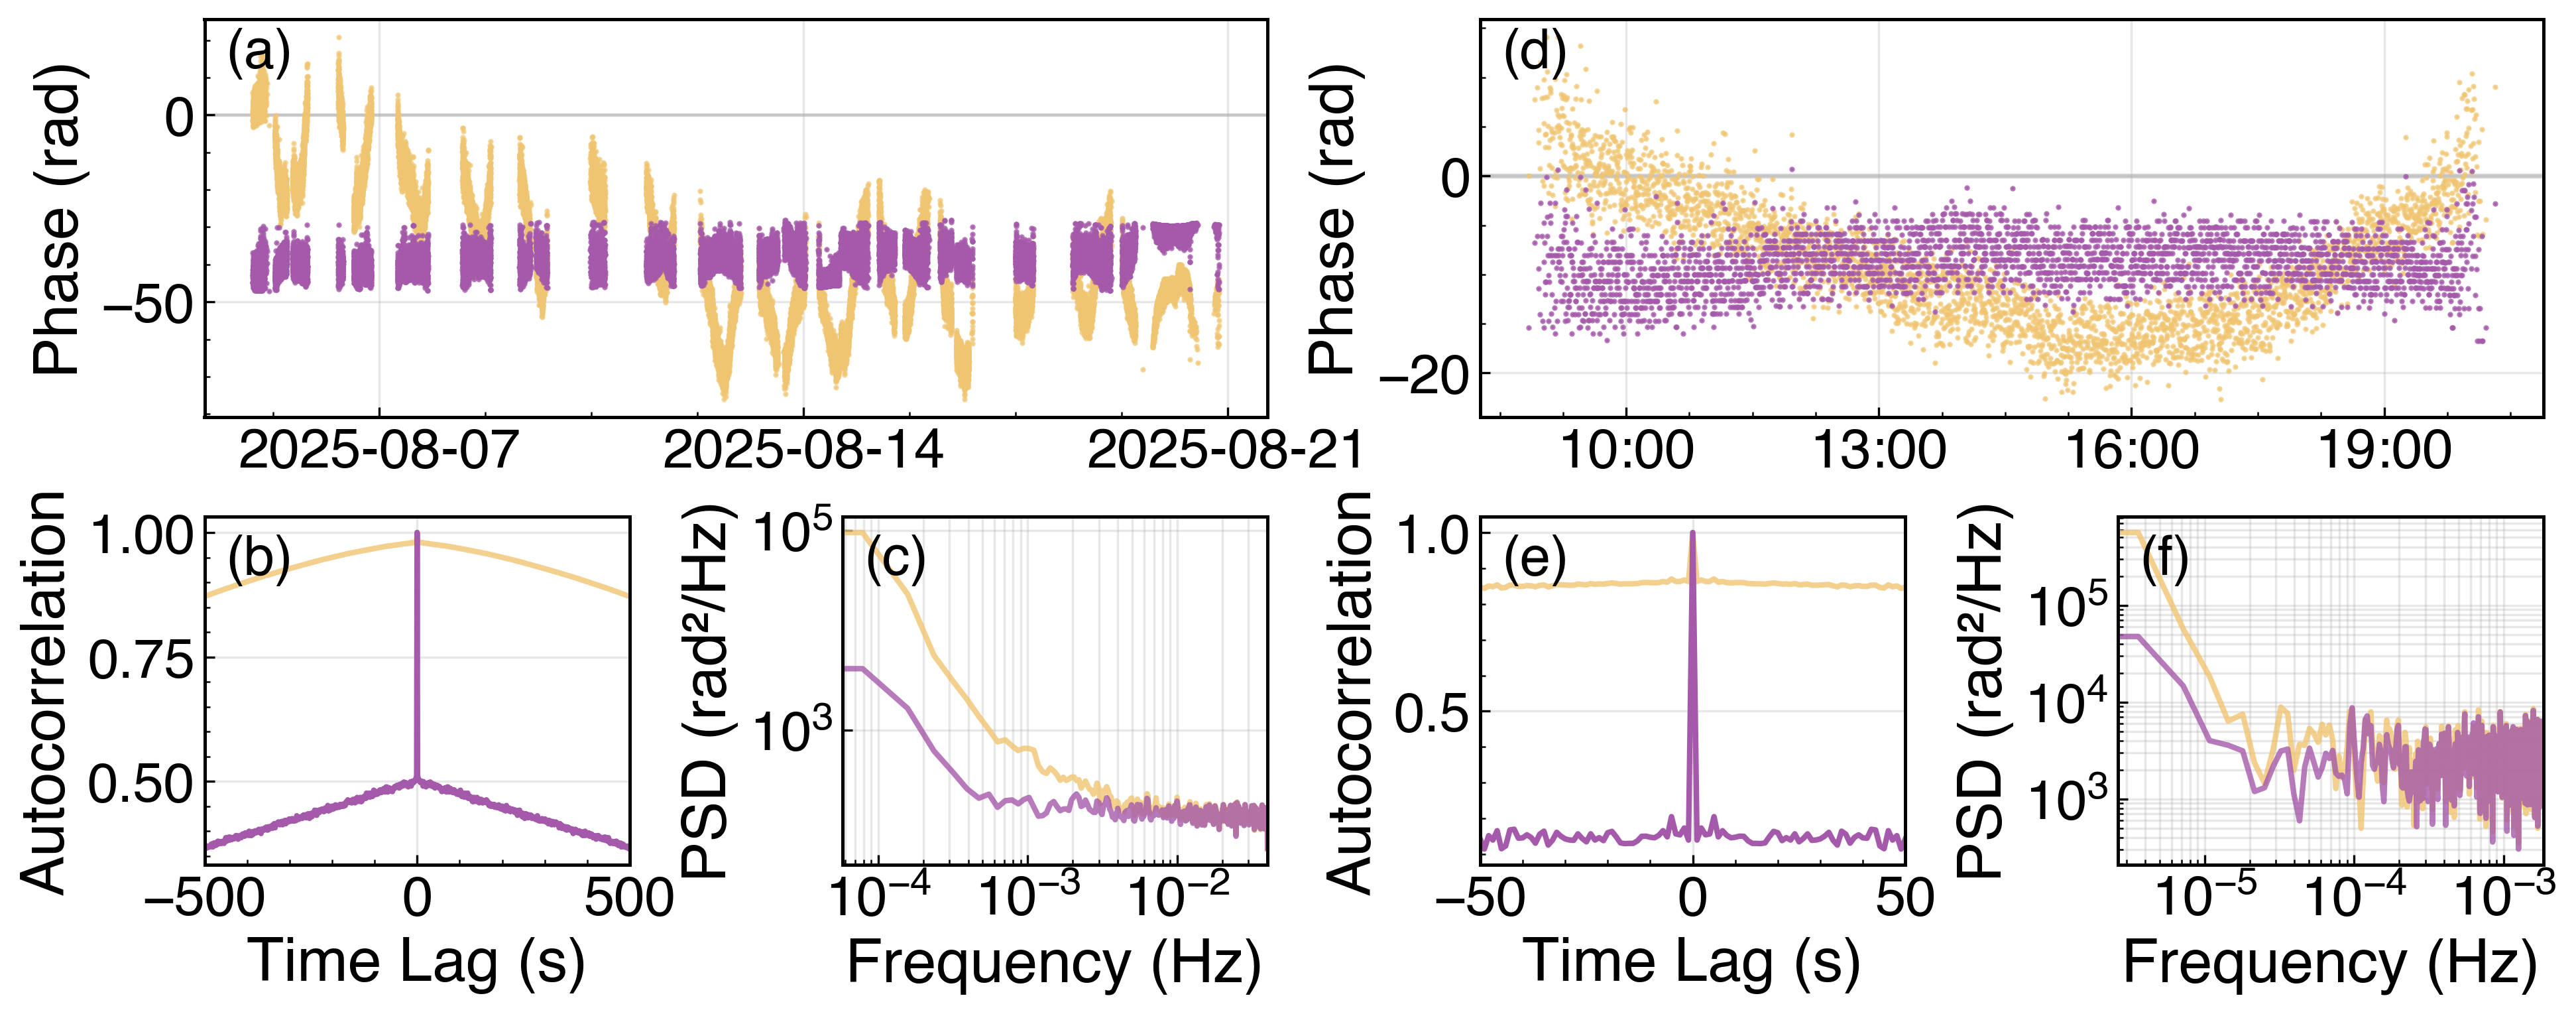

In [2]:
# Define coefficients
coefficients = {
    'alpha0': 1.000027,
    'alphaT': -8.940360e-7,
    'alphaH': -1.780000e-8,
    'alphaP': 2.569000e-9
}

# Load datasets
df1 = pd.read_csv('../data/dataset_20250615_20250824_with_timestamp.csv')
df2 = pd.read_csv('../data/dataset_20250101_20250112_with_timestamp.csv')
df3 = pd.read_csv('../data/dataset_20250805_20250820_with_timestamp.csv')

# Combine for long-term analysis
df_year = pd.concat([df1, df2], ignore_index=True)
df_month = df3

# Define short-term window
start_time = '2025-08-08 00:00:00+00:00'  
end_time = '2025-08-09 00:00:00+00:00'
df_day = df3[(df3['time'] >= start_time) & (df3['time'] <= end_time)]

# Create combined figure
fig, stats = create_combined_figure(
    df_long_term=df_month,
    df_short_term=df_day,
    coefficients=coefficients,
    save_path='../figures/combined_figure.png'
)

plt.show()
